In [125]:
import numpy as np
import sympy as symp
import scipy as scip
import matplotlib.pyplot as plt
import math as math 

Using 37%HAN-63%H2O2 + RP-1 Propellant

Oxidizer to Fuel Ratio = 7.1:1
Chamber pressure = 3.00 MPa
Chamber temperature = 2821.9317 K
Throat diameter = 25.65 mm
Nozzle expansion ratio = 125
Nozzle exit diameter = 0.2868 m
Nozzle exit area = 0.0646 m^2

Exhaust mach number = 5.0485
Effective exhaust velocity = 3053.1928 m/s
C* Efficiency = 1607.7649 m/s
Exhaust temperature = 796.4910 K
Exhaust pressure = 1495.3164 Pa
Specific Impulse (Isp) = 311.3279 s
Density Impulse = 482558.2543 kg-s/m^3

Propellant Mass Flow Rate = 0.9642 Kg/s
Fuel Mass Flow Rate = 0.1190 Kg/s
Oxidizer Mass Flow Rate = 0.8452 Kg/s
Oxidizer Volumetric Flow Rate = 0.5282 L/s

Thrust = 3040.4473 N

Delta V total = 3931.8569 m/s
Total propellant mass used = 367.4650 kg
    Fuel mass used= 45.3661 kg
    Fuel volume = 56.7076 L
    Oxidizer mass used= 322.0990 kg
    Oxidizer volume = 207.8058 L
    Propellant mass used at parking = 280.3434 kg
    Propellant mass used at injection = 87.1216 kg
Dry mass = 140.0000 kg
Tota

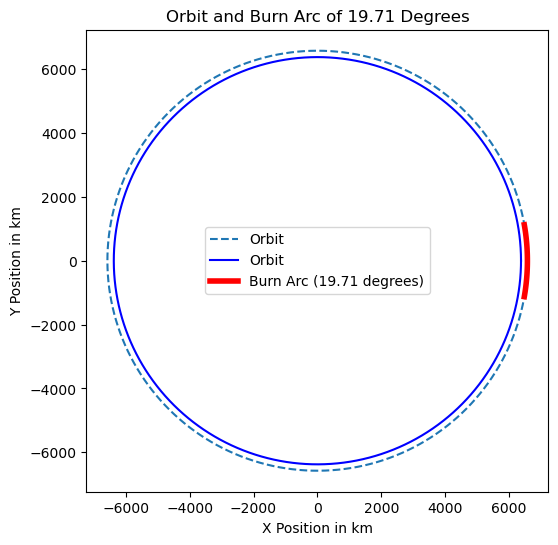

[311.32790601935176, 0.3898137788662623]

In [126]:
def rocket_performance(Name, Pc, dt, Tc, gamma_comb, gamma_exit, R_comb, R_exit, OF, Pa, g0, mass_dry, nozzle_expansion_ratio, density_ox, density_fuel, h1, h2, disp):
    # Derived values
    At = math.pi/4*dt**2
    dt2 = math.sqrt(4 / math.pi * nozzle_expansion_ratio * At)  # Nozzle exit diameter
    Ae = nozzle_expansion_ratio * At  # Nozzle exit area in square meters
    
    gamma_avg = (gamma_comb + gamma_exit)/2
    R_avg = (R_comb + R_exit)/2
    
    # Step 2: Calculate Effective Exhaust Velocity (ve) and Specific Impulse (ISP)
    def exit_mach_number_func(M, nozzle_expansion_ratio, gamma):
        return (nozzle_expansion_ratio - (1 / M) * ((2 / (gamma + 1)) * (1 + (gamma - 1) / 2 * M**2))**((gamma + 1) / (2 * (gamma - 1))))

    Me = float(scip.optimize.fsolve(exit_mach_number_func, 5, args=(nozzle_expansion_ratio, gamma_avg))[0])
    Te = Tc * (1 + (gamma_avg - 1) / 2 * Me**2) ** -1
    Pe = Pc * (1 + (gamma_avg - 1) / 2 * Me**2) ** (-gamma_avg / (gamma_avg - 1))
    ve = Me * math.sqrt(gamma_exit * R_exit * Te)
    c_star = math.sqrt(R_comb*Tc)/(math.sqrt(gamma_comb)*(2/(gamma_comb+1))**((gamma_comb+1)/(2*gamma_comb-2)))
    ISP = ve / g0
    density_ISP = ISP * density_ox
    
    # Step 3: Calculate the mass flow rate (dot_m)
    mass_flow_rate = (Pc * At / math.sqrt(Tc)) * math.sqrt(gamma_comb / R_comb) * ((2 / (gamma_comb + 1)) ** ((gamma_comb + 1) / (2 * (gamma_comb - 1))))
    oxidizer_mass_flow_rate = mass_flow_rate * OF / (1 + OF)
    fuel_mass_flow_rate = mass_flow_rate - oxidizer_mass_flow_rate

    # Step 4: Calculate Thrust (Ft)
    thrust = mass_flow_rate * ve + (Pe - Pa) * Ae

    # Step 5: Delta V Calculation
    R_E = 6378e3  # Earth's radius in meters
    mu = 3.985894e14  # Standard gravitational parameter for Earth in m^3/s^2

    # Initial and final orbital radii
    r1 = R_E + h1
    r2 = R_E + h2

    # Semi-major axis of the transfer orbit
    a_t = (r1 + r2) / 2

    # Orbital velocities
    v1 = math.sqrt(mu / r1)  # Initial orbit velocity
    vp = math.sqrt((2 * mu / r1) - (mu / a_t))  # Velocity at perigee of transfer orbit
    va = math.sqrt((2 * mu / r2) - (mu / a_t))  # Velocity at apogee of transfer orbit
    v2 = math.sqrt(mu / r2)  # Final orbit velocity

    # Delta V for each burn
    delta_v1 = vp - v1
    delta_v2 = v2 - va

    # Total Delta V
    delta_v_total = delta_v1 + delta_v2

    # Using Tsiolkovsky's rocket equation to find propellant mass
    mass_propellant = mass_dry * (math.exp(delta_v_total / ve) - 1)
    mass_oxidizer = mass_propellant * OF / (OF + 1)
    volume_oxidizer = mass_oxidizer/density_ox
    burn_time = mass_oxidizer / oxidizer_mass_flow_rate
    
    # Calculate final mass after first burn
    mass_initial = mass_propellant + mass_dry
    mass_f1 = mass_initial * math.exp(-delta_v1 / ve)
    
    # Calculate propellant mass required for first burn
    mass_propellant_parking= mass_initial - mass_f1
    
    # Calculate final mass after second burn
    mass_f2 = mass_f1 * math.exp(-delta_v2 / ve)

    # Calculate propellant mass required for second burn
    mass_propellant_injection = mass_f1 - mass_f2
    
    parking_burn_time = mass_propellant_parking * OF / (OF+1) / oxidizer_mass_flow_rate
    injection_burn_time = mass_propellant_injection * OF / (OF+1) / oxidizer_mass_flow_rate


    # Calculate the orbital period at LEO (T)
    LEO_period = 2 * math.pi * math.sqrt(r1**3 / mu)
    
    # Calculate time to traverse 10 degrees of the orbit
    arc_degrees = parking_burn_time*360/LEO_period
    
    #Nozzle Length for 100% Bell Nozzle
    LN_cone = 0.8*(math.sqrt(nozzle_expansion_ratio)-1)*dt/2/math.tan(math.radians(15))
    
    
    def plot_orbit_and_burn_arc(orbit_radius, arc_degrees):
        """
        Visualize the orbit and highlight the arc corresponding to a burn.
    
        Parameters:
        - orbit_radius: Radius of the orbit (in arbitrary units, e.g., km or AU)
        - arc_degrees: Arc length in degrees over which the burn occurs
        """
        # Full circle (orbit) points
        theta_full = np.linspace(0, 2 * np.pi, 1000)
        x_full = orbit_radius * np.cos(theta_full)
        y_full = orbit_radius * np.sin(theta_full)
        x_earth = 6378 * np.cos(theta_full)
        y_earth = 6378 * np.sin(theta_full)
        
        # Arc for the burn
        arc_radians = np.deg2rad(arc_degrees / 2)
        theta_arc = np.linspace(-arc_radians, arc_radians, 100)
        x_arc = orbit_radius * np.cos(theta_arc)
        y_arc = orbit_radius * np.sin(theta_arc)
    
        # Plotting the full orbit
        plt.figure(figsize=(6, 6))
        plt.plot(x_full, y_full, label='Orbit', linestyle='--')
        plt.plot(x_earth, y_earth, label='Orbit', linestyle='-', color='blue')
        
        # Highlighting the arc
        plt.plot(x_arc, y_arc, color='red', label=f'Burn Arc ({arc_degrees:.2f} degrees)', linestyle='-', linewidth=4)
    
        # Plot aesthetics
        plt.title(f"Orbit and Burn Arc of {arc_degrees:.2f} Degrees")
        plt.xlabel('X Position in km')
        plt.ylabel('Y Position in km')
        plt.axhline(0, color='black', linewidth=0)
        plt.axvline(0, color='black', linewidth=0)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.legend()
        plt.show()
        
        return
    
    if disp:
        print(f"Using {Name}\n")

        # Print basic parameters
        print(f"Oxidizer to Fuel Ratio = {OF}:1")
        print(f"Chamber pressure = {Pc*1e-6:.2f} MPa")
        print(f"Chamber temperature = {Tc} K")
        print(f"Throat diameter = {dt*1000} mm")
        print(f"Nozzle expansion ratio = {nozzle_expansion_ratio}")
        print(f"Nozzle exit diameter = {dt2:.4f} m")
        print(f"Nozzle exit area = {Ae:.4f} m^2")
        
        print(f"\nExhaust mach number = {Me:.4f}")
        print(f"Effective exhaust velocity = {ve:.4f} m/s")
        print(f"C* Efficiency = {c_star:.4f} m/s")
        print(f"Exhaust temperature = {Te:.4f} K")
        print(f"Exhaust pressure = {Pe:.4f} Pa")
        print(f"Specific Impulse (Isp) = {ISP:.4f} s")
        print(f"Density Impulse = {density_ISP:.4f} kg-s/m^3")
    
        print(f"\nPropellant Mass Flow Rate = {mass_flow_rate:.4f} Kg/s")
        print(f"Fuel Mass Flow Rate = {fuel_mass_flow_rate:.4f} Kg/s")
        print(f"Oxidizer Mass Flow Rate = {oxidizer_mass_flow_rate:.4f} Kg/s")
        print(f"Oxidizer Volumetric Flow Rate = {oxidizer_mass_flow_rate/1600*1000:.4f} L/s")
        
        print(f"\nThrust = {thrust:.4f} N")
        
        print(f"\nDelta V total = {delta_v_total:.4f} m/s")
        print(f"Total propellant mass used = {mass_propellant:.4f} kg")
        print(f"    Fuel mass used= {mass_propellant - mass_oxidizer:.4f} kg")
        print(f"    Fuel volume = {(mass_propellant - mass_oxidizer)/density_fuel*1000:.4f} L")
        print(f"    Oxidizer mass used= {mass_oxidizer:.4f} kg")
        print(f"    Oxidizer volume = {mass_oxidizer/density_ox*1000:.4f} L")
        print(f"    Propellant mass used at parking = {mass_propellant_parking:.4f} kg")
        print(f"    Propellant mass used at injection = {mass_propellant_injection:.4f} kg")
        print(f"Dry mass = {mass_dry:.4f} kg")
        print(f"Total LEO wet mass = {mass_initial:.4f} kg")
        print(f"Total burn time = {burn_time:.2f} s")
        print(f"    Parking burn time = {parking_burn_time:.2f} s")
        print(f"    Injection burn time = {injection_burn_time:.2f} s")
        print(f"Orbital arc degrees over parking burn = {arc_degrees:.2f} deg")
        
        plot_orbit_and_burn_arc(r1/1000, arc_degrees)
        
    return [ISP, LN_cone]
'''
c_star = 1692.9
OF = 6.3
gamma = 
'''
# Example usage of the function with the given constants 1.1371
# From CEA, gamma at combustion chamber is 1.1371, and nozzle exit 1.2420, avg. 1.18955
# From CEA, Gas Constant (R) at combustion chamber is (8.3144598 J/mol-K)/21.468e-3, and nozzle exit (8.3144598 J/mol-K)/21.930e-3, avg. = 383.215917
# Assumed Ac/At = 10 (typical range, smaller the engine larger the Ac/At) in CEA. It doesn't affect rocket performance but the mixing of fuel (we assume the propellants are mixed properly)
#gamma_exit=1.2420  R_exit=8.3144598/21.930e-3
Isp_plot = []
LN = []
expans_ratio = []

#print(rocket_performance(Name = '37%HAN-63%H2O2 + RP-1 Propellant', Pc=30e5, dt=0.0254, Tc=2975.78, gamma_comb=1.1371, gamma_exit=1.2420, R_comb=8.3144598/21.468e-3, R_exit=8.3144598/21.930e-3, OF=6.3, Pa=0, g0=9.807, mass_dry=100, nozzle_expansion_ratio=125, density_ox=1550, h1=200e3, h2=35786e3, disp=False)[1])

for i in range(20,200):
    expans_ratio.append(i)
    Isp_plot.append(rocket_performance(Name = '37%HAN-63%H2O2 + RP-1 Propellant', Pc=30e5, dt=0.0254, Tc=2975.78, gamma_comb=1.1371, gamma_exit=1.2420, R_comb=8.3144598/21.468e-3, R_exit=8.3144598/21.930e-3, OF=6.3, Pa=9e-9, g0=9.807, mass_dry=100, nozzle_expansion_ratio=i, density_ox=1550, density_fuel=800, h1=200e3, h2=35786e3, disp=False)[0])
    
    LN.append(rocket_performance(Name = '37%HAN-63%H2O2 + RP-1 Propellant', Pc=30e5, dt=0.0254, Tc=2975.78, gamma_comb=1.1371, gamma_exit=1.2420, R_comb=8.3144598/21.468e-3, R_exit=8.3144598/21.930e-3, OF=6.3, Pa=9e-9, g0=9.807, mass_dry=100, nozzle_expansion_ratio=i, density_ox=1550, density_fuel=800, h1=200e3, h2=35786e3, disp=False)[1])


'''
plt.plot(list(np.array(expans_ratio)/max(np.array(expans_ratio))),list(np.array(Isp_plot)/max(np.array(Isp_plot))), label='Isp')
plt.plot(list(np.array(expans_ratio)/max(np.array(expans_ratio))),list(np.array(LN)/max(np.array(LN))), label='length')
plt.plot(list(np.array(expans_ratio)/max(np.array(expans_ratio))),list(np.array(Isp_plot)/np.array(LN)/max(np.array(Isp_plot)/np.array(LN))), label='Isp/Length')
'''
'''
plt.plot(list(np.array(expans_ratio)),list(np.array(Isp_plot)), label='Isp')
plt.plot(list(np.array(expans_ratio)),list(np.array(LN)*100), label='length')
#plt.plot(list(np.array(expans_ratio)),list(np.array(Isp_plot)/np.array(LN)), label='Isp/Length')

print(f"Max Isp = {max(np.array(Isp_plot))} s")
plt.legend()

plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks(np.linspace(0, 1.0, num=11))
plt.yticks(np.linspace(0, 1.0, num=11))


#plt.xlim(20,2000)
#plt.xticks(np.linspace(0, 1.0, num=11))
plt.yticks(np.linspace(0, 350, num=21))
plt.grid(True)
'''
#CEA-Run
#rocket_performance(Name = '37%HAN-63%H2O2 + RP-1 Propellant', Pc=30e5, dt=0.0254*1, Tc=2975.78, gamma_comb=1.1371, gamma_exit=1.2420, R_comb=8.3144598/21.468e-3, R_exit=8.3144598/21.930e-3, OF=6.3, Pa=0, g0=9.807, mass_dry=140, nozzle_expansion_ratio=80, density_ox=1550, density_fuel=800, h1=200e3, h2=35786e3, disp=True)

#RPA-Run
rocket_performance(Name = '37%HAN-63%H2O2 + RP-1 Propellant', Pc=30e5, dt=0.02565*1, Tc=2821.9317, gamma_comb=1.1467, gamma_exit=1.2524, R_comb=8.3144598/22.3014e-3, R_exit=8.3144598/22.6760e-3, OF=7.1, Pa=0, g0=9.807, mass_dry=140, nozzle_expansion_ratio=125, density_ox=1550, density_fuel=800, h1=200e3, h2=35786e3, disp=True)



In [127]:
def equation(D2, V, D1):
    return V-math.pi*(((D1+D2)/4)-D1/2)**2*2*math.pi*((D1+D2)/4)

V = 59.4645e-3
#D2 = 847e-3
D1 = 350e-3
D2 = float(scip.optimize.fsolve(equation, 0.5, args=(V, D1))[0])
print(f"D2 = {D2*1000:.3f} mm")
print(f"R = {((D1+D2)/4)*1000:.4f} mm")
print(f"r = {(((D1+D2)/4)-D1/2)*1000:.4f} mm")

D2 = 765.700 mm
R = 278.9251 mm
r = 103.9251 mm
